<a href="https://colab.research.google.com/github/amilyk/Agentic-ai-notes/blob/main/Chat_generation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install anthropic

In [2]:
!touch .env
!echo "OPENAI_API_KEY=your-openai-key" >> .env
!echo "ANTHROPIC_API_KEY=your-ANTHROPIC-key" >> .env
!echo "DEEPSEEK_API_KEY=your-deepseek-key" >> .env
!echo "ZHIPU_API_KEY=your-zhipu-key" >> .env

In [3]:
import os
from dotenv import load_dotenv, find_dotenv
_ = load_dotenv(find_dotenv())

# openai_api_key = os.getenv("OPENAI_API_KEY")
# anthropic_api_key = os.getenv("ANTHROPIC_API_KEY")
# deepseek_api_key = os.getenv("DEEPSEEK_API_KEY")
# zhipu_api_key = os.getenv("ZHIPU_API_KEY")

In [4]:
import re
import json
import utils

# 加载数据集

In [5]:
df = utils.load_and_prepare_data('coffee_sales.csv')
utils.print_html(df.sample(n=5), title="Random Sample of Coffee Sales Data")

date,time,cash_type,card,price,coffee_name,quarter,month,year
2024-03-02,06:57,card,ANON-0000-0000-0010,2.890,Americano,1,3,2024
2024-06-27,10:23,card,ANON-0000-0000-0327,2.792,Cortado,2,6,2024
2024-04-20,11:17,card,ANON-0000-0000-0012,3.282,Americano with Milk,2,4,2024
2025-03-05,14:29,card,ANON-0000-0000-1264,3.576,Cocoa,1,3,2025
2024-09-03,06:34,card,ANON-0000-0000-0168,3.282,Cappuccino,3,9,2024


# 产生版本V1

In [6]:
def generate_chart_code(instruction: str, model: str, out_path_v1: str) -> str:
    """Generate Python code to make a plot with matplotlib using tag-based wrapping."""

    prompt = f"""
    You are a data visualization expert.

    Return your answer *strictly* in this format:

    <execute_python>
    # valid python code here
    </execute_python>

    Do not add explanations, only the tags and the code.

    The code should create a visualization from a DataFrame 'df' with these columns:
    - date (M/D/YY)
    - time (HH:MM)
    - cash_type (card or cash)
    - card (string)
    - price (number)
    - coffee_name (string)
    - quarter (1-4)
    - month (1-12)
    - year (YYYY)

    User instruction: {instruction}

    Requirements for the code:
    1. Assume the DataFrame is already loaded as 'df'.
    2. Use matplotlib for plotting.
    3. Add clear title, axis labels, and legend if needed.
    4. Save the figure as '{out_path_v1}' with dpi=300.
    5. Do not call plt.show().
    6. Close all plots with plt.close().
    7. Add all necessary import python statements

    Return ONLY the code wrapped in <execute_python> tags.
    """

    response = utils.get_response(model, prompt)
    return response

In [14]:
# Generate initial code by deepseek
code_v1 = generate_chart_code(
    instruction="Create a plot comparing Q1 coffee sales in 2024 and 2025 using the data in coffee_sales.csv.",
    model="deepseek-chat",
    out_path_v1="chart_v1.png"
)

utils.print_html(code_v1, title="LLM output with first draft code")

In [15]:
# Generate initial code by zhipu
# code_v1 = generate_chart_code(
#     instruction="Create a plot comparing Q1 coffee sales in 2024 and 2025 using the data in coffee_sales.csv.",
#     model="glm-4",
#     out_path_v1="chart_v1.png"
# )

# utils.print_html(code_v1, title="LLM output with first draft code")

# 执行code并产生Chart


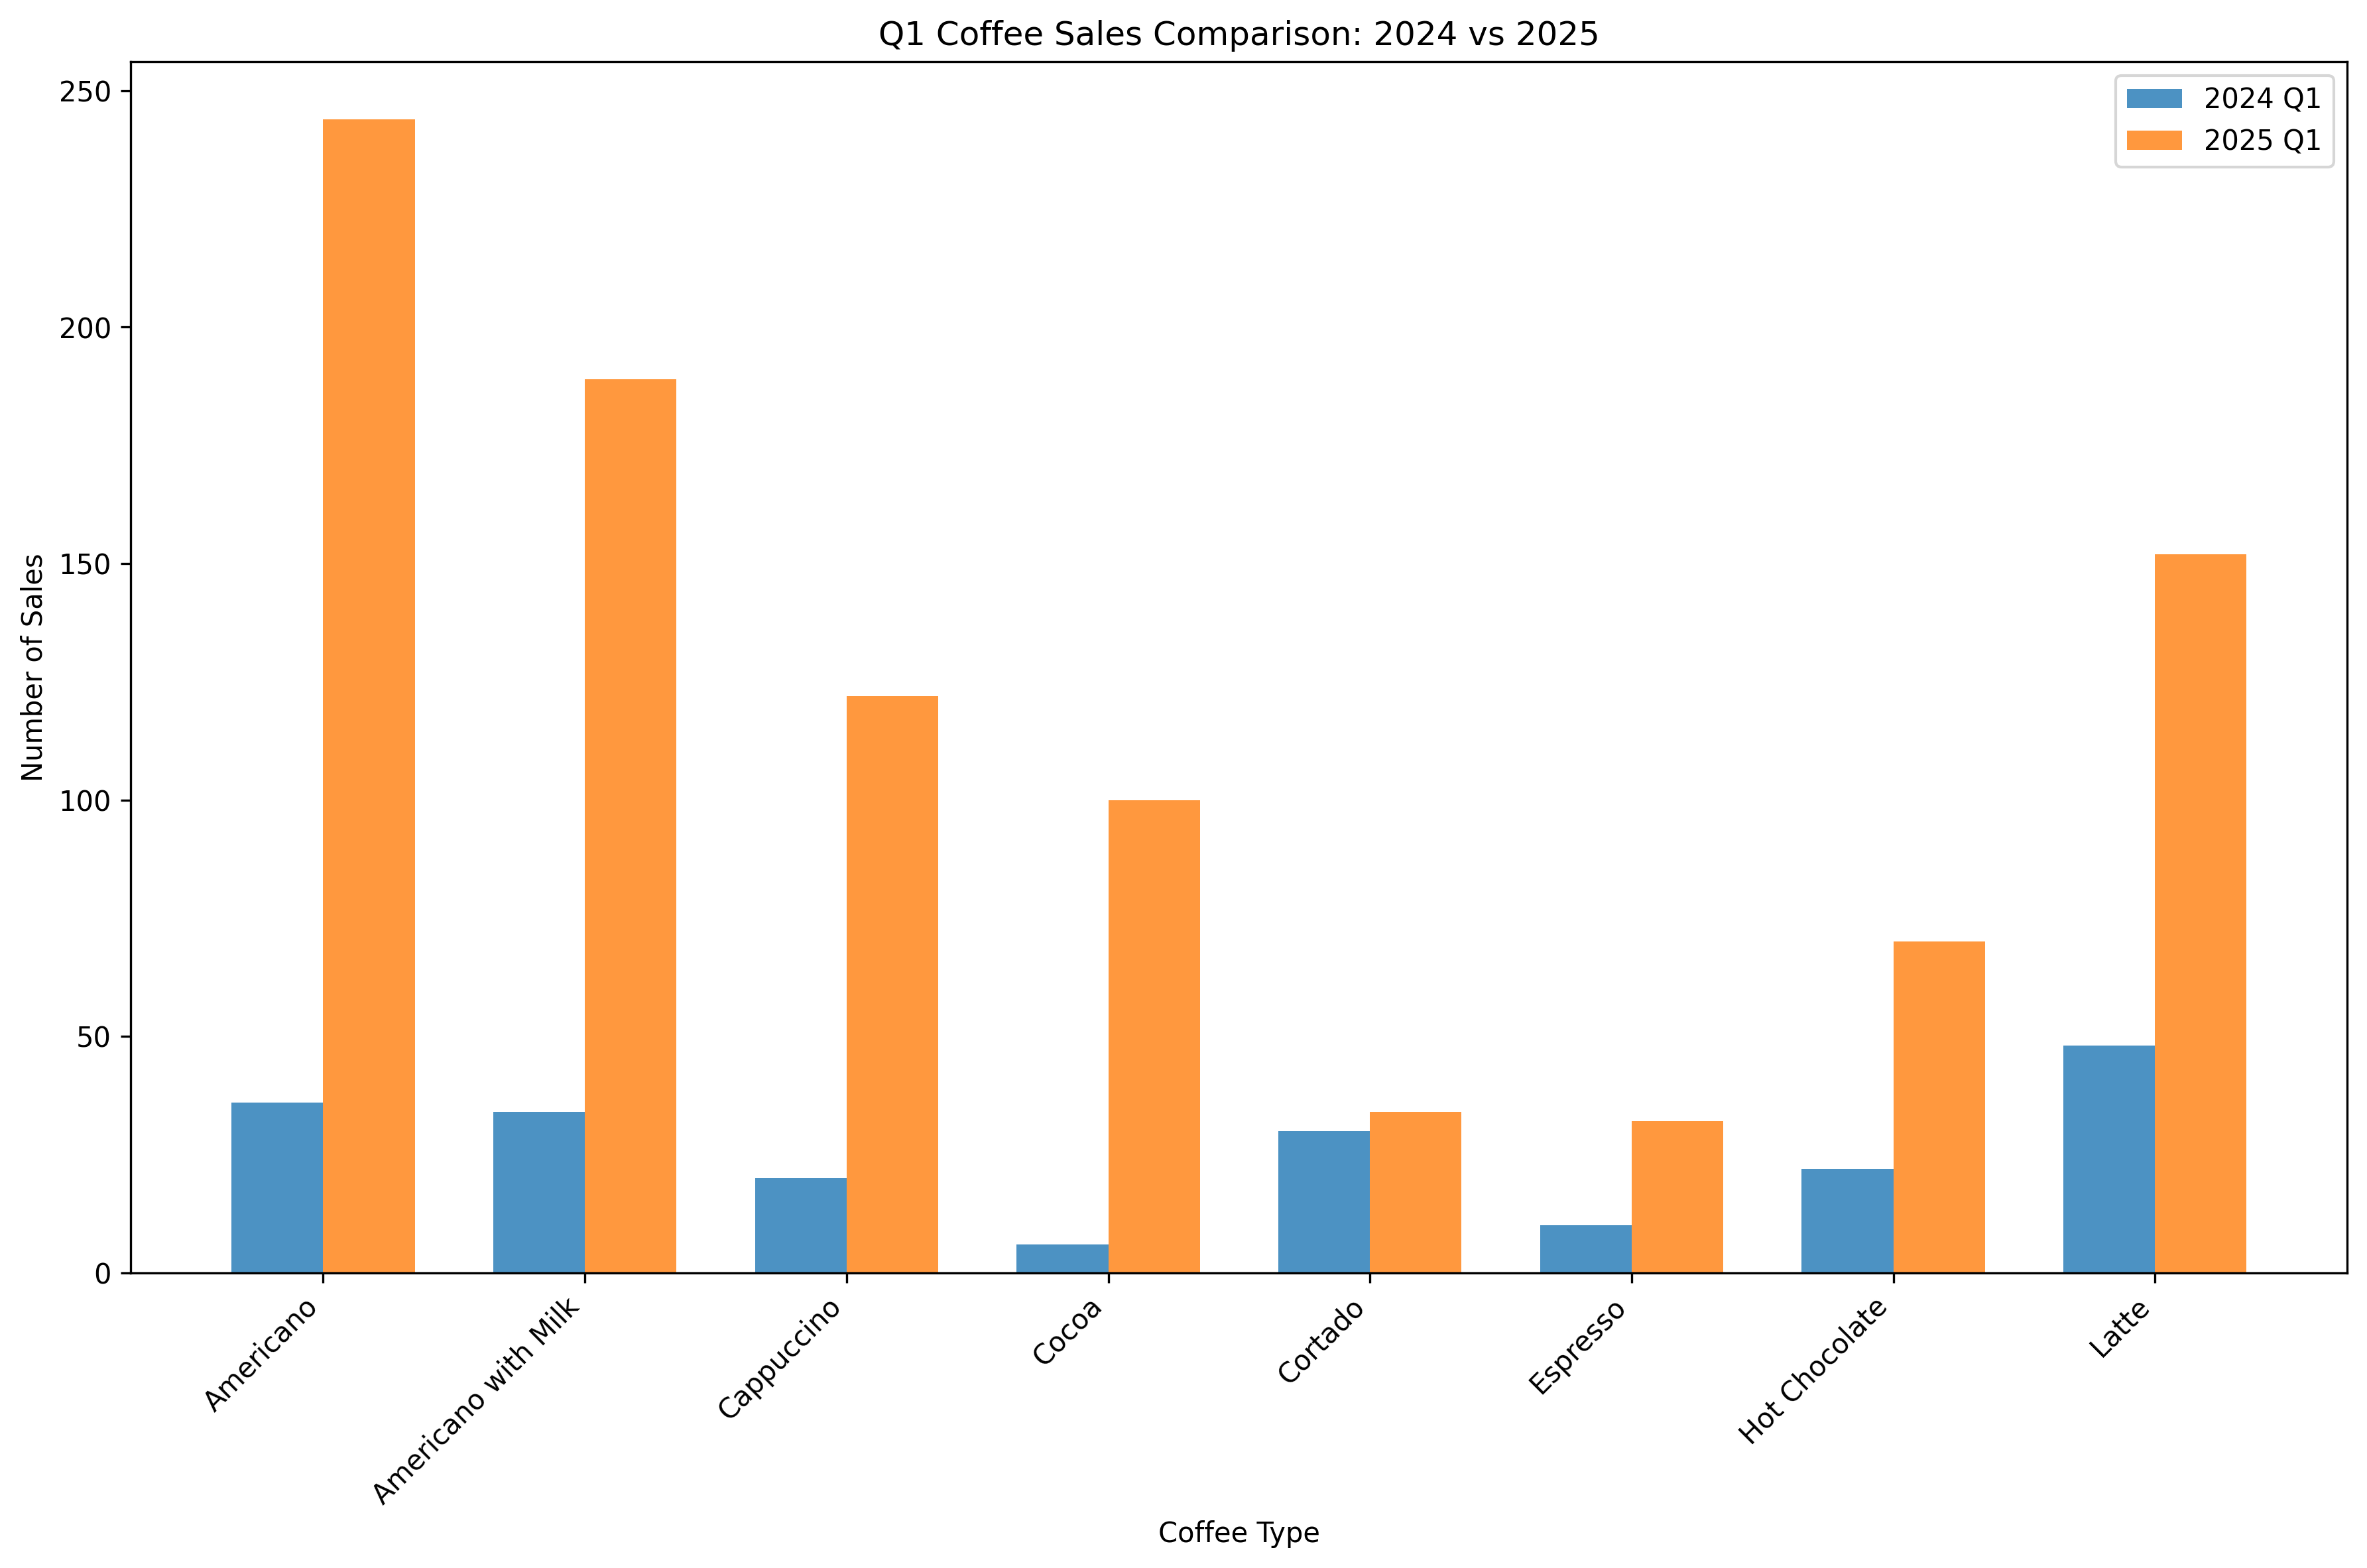

In [16]:
# Get the code within the <execute_python> tags
match = re.search(r"<execute_python>([\s\S]*?)</execute_python>", code_v1)
if match:
    initial_code = match.group(1).strip()
    utils.print_html(initial_code, title="Extracted Code to Execute")
    exec_globals = {"df": df}
    exec(initial_code, exec_globals)

# If code run successfully, the file chart_v1.png should have been generated
utils.print_html(
    content="chart_v1.png",
    title="Generated Chart (V1)",
    is_image=True
)

# 反思并产生新code

In [17]:
def reflect_on_image_and_regenerate(
    chart_path: str,
    instruction: str,
    model_name: str,
    out_path_v2: str,
    code_v1: str,
) -> tuple[str, str]:
    """
    Critique the chart IMAGE and the original code against the instruction,
    then return refined matplotlib code.
    Returns (feedback, refined_code_with_tags).
    Supports OpenAI and Anthropic (Claude).
    """
    media_type, b64 = utils.encode_image_b64(chart_path)


    prompt = f"""
    You are a data visualization expert.
    Your task: critique the attached chart and the original code against the given instruction,
    then return improved matplotlib code.

    Original code (for context):
    {code_v1}

    OUTPUT FORMAT (STRICT!):
    1) First line: a valid JSON object with ONLY the "feedback" field.
    Example: {{"feedback": "The legend is unclear and the axis labels overlap."}}

    2) After a newline, output ONLY the refined Python code wrapped in:
    <execute_python>
    ...
    </execute_python>

    3) Import all necessary libraries in the code. Don't assume any imports from the original code.

    HARD CONSTRAINTS:
    - Do NOT include Markdown, backticks, or any extra prose outside the two parts above.
    - Use pandas/matplotlib only (no seaborn).
    - Assume df already exists; do not read from files.
    - Save to '{out_path_v2}' with dpi=300.
    - Always call plt.close() at the end (no plt.show()).
    - Include all necessary import statements.

    Schema (columns available in df):
    - date (M/D/YY)
    - time (HH:MM)
    - cash_type (card or cash)
    - card (string)
    - price (number)
    - coffee_name (string)
    - quarter (1-4)
    - month (1-12)
    - year (YYYY)

    Instruction:
    {instruction}
    """


    # In case the name is "Claude" or "Anthropic", use the safe helper
    lower = model_name.lower()
    if "claude" in lower or "anthropic" in lower:
        # ✅ Use the safe helper that joins all text blocks and adds a system prompt
        content = utils.image_anthropic_call(model_name, prompt, media_type, b64)
    elif "deepseek" in lower:
        content = utils.image_deepseek_call(model_name, prompt, media_type, b64)
    elif "glm" in lower:
        content = utils.image_zhipu_call(model_name, prompt, media_type, b64)
    else:
        content = utils.image_openai_call(model_name, prompt, media_type, b64)

    # --- Parse ONLY the first JSON line (feedback) ---
    lines = content.strip().splitlines()
    json_line = lines[0].strip() if lines else ""

    try:
        obj = json.loads(json_line)
    except Exception as e:
        # Fallback: try to capture the first {...} in all the content
        m_json = re.search(r"\{.*?\}", content, flags=re.DOTALL)
        if m_json:
            try:
                obj = json.loads(m_json.group(0))
            except Exception as e2:
                obj = {"feedback": f"Failed to parse JSON: {e2}", "refined_code": ""}
        else:
            obj = {"feedback": f"Failed to find JSON: {e}", "refined_code": ""}

    # --- Extract refined code from <execute_python>...</execute_python> ---
    m_code = re.search(r"<execute_python>([\s\S]*?)</execute_python>", content)
    refined_code_body = m_code.group(1).strip() if m_code else ""
    refined_code = utils.ensure_execute_python_tags(refined_code_body)

    feedback = str(obj.get("feedback", "")).strip()
    return feedback, refined_code

In [18]:
feedback, code_v2 = reflect_on_image_and_regenerate(
    chart_path="chart_v1.png",
    instruction="Create a plot comparing Q1 coffee sales in 2024 and 2025 using the data in coffee_sales.csv.",
    model_name="glm-4v-plus",  #deepseek-vl-7b-chat
    out_path_v2="chart_v2.png",
    code_v1=code_v1,   # pass in the original code for context
)

utils.print_html(feedback, title="Feedback on V1 Chart")
utils.print_html(code_v2, title="Regenerated Code Output (V2)")


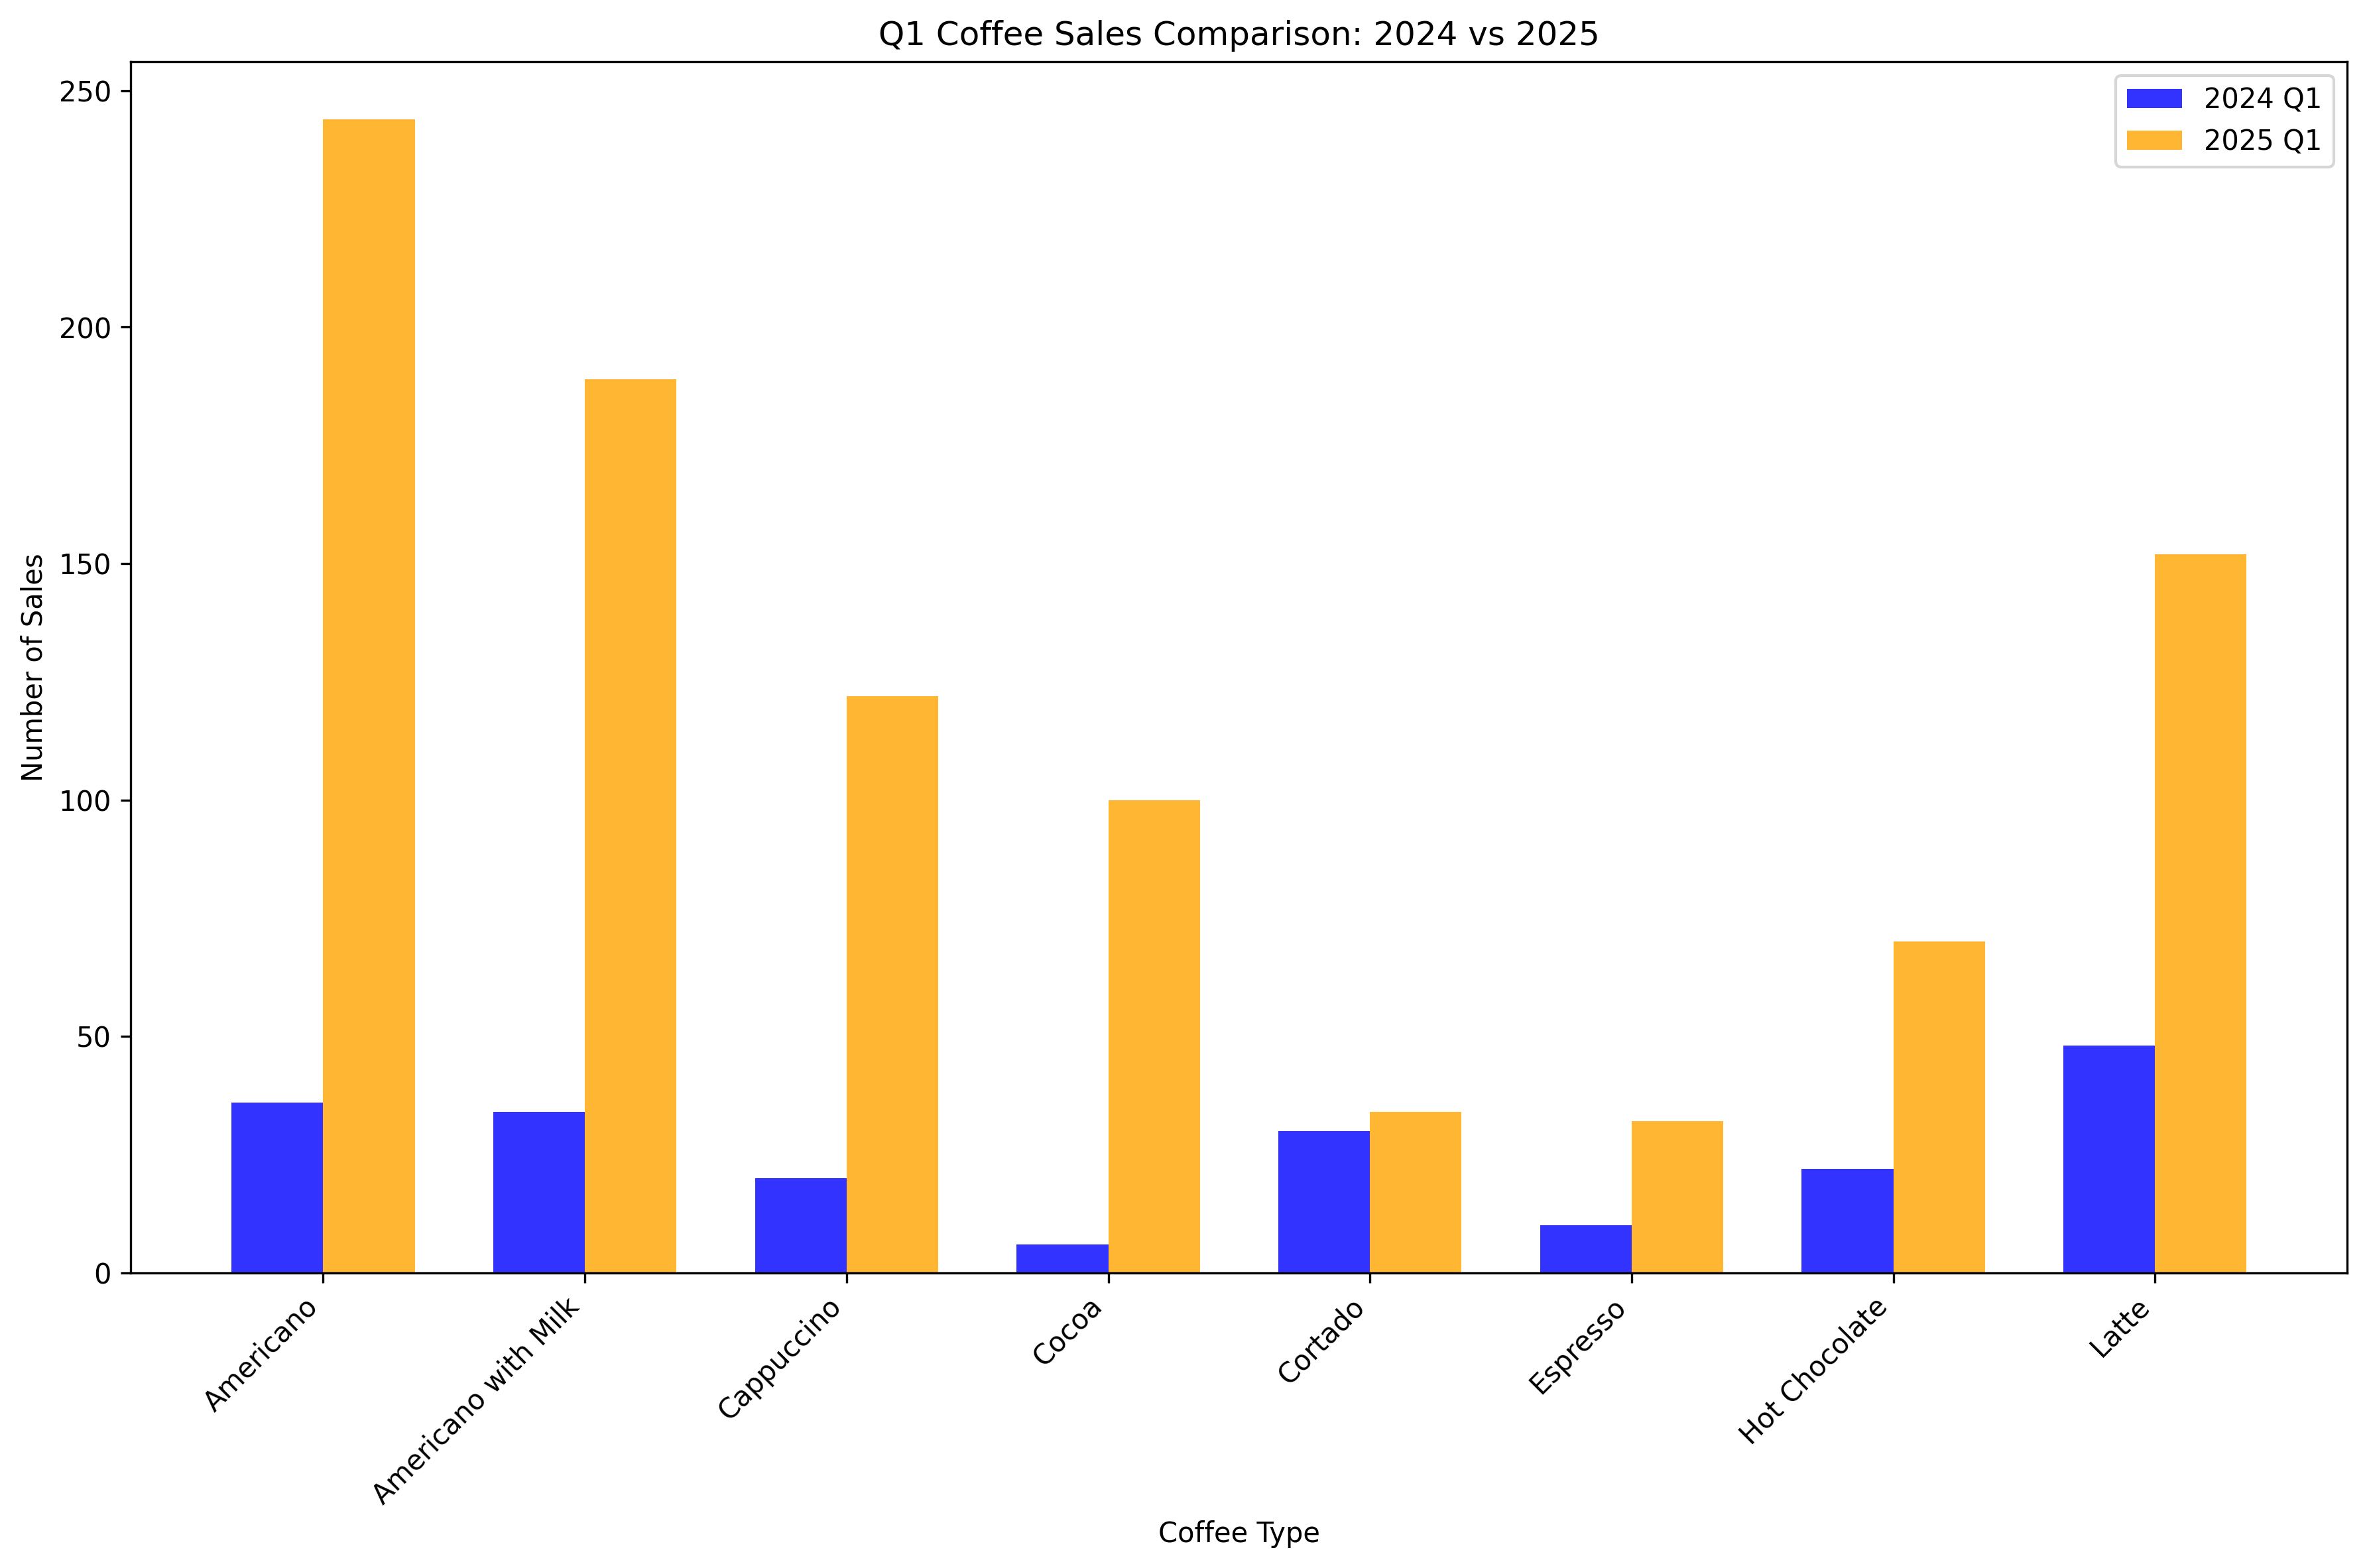

In [19]:
# Get the code within the <execute_python> tags
match = re.search(r"<execute_python>([\s\S]*?)</execute_python>", code_v2)
if match:
    reflected_code = match.group(1).strip()
    exec_globals = {"df": df}
    exec(reflected_code, exec_globals)

# If code run successfully, the file chart_v2.png should have been generated
utils.print_html(
    content="chart_v2.png",
    title="Regenerated Chart (V2)",
    is_image=True
)

# 包含反思生成路径
query -> code1, chart1 -> reflected_code:code2, chart2

In [20]:
def run_workflow(
    dataset_path: str,
    user_instructions: str,
    generation_model: str,
    reflection_model: str,
    image_basename: str = "chart",
):
    """
    End-to-end pipeline:
      1) load dataset
      2) generate V1 code
      3) execute V1 → produce chart_v1.png
      4) reflect on V1 (image + original code) → feedback + refined code
      5) execute V2 → produce chart_v2.png

    Returns a dict with all artifacts (codes, feedback, image paths).
    """
    # 0) Load dataset; utils handles parsing and feature derivations (e.g., year/quarter)
    df = utils.load_and_prepare_data(dataset_path)
    utils.print_html(df.sample(n=5), title="Random Sample of Dataset")

    # Paths to store charts
    out_v1 = f"{image_basename}_v1.png"
    out_v2 = f"{image_basename}_v2.png"

    # 1) Generate code (V1)
    utils.print_html("Step 1: Generating chart code (V1)… 📈")
    code_v1 = generate_chart_code(
        instruction=user_instructions,
        model=generation_model,
        out_path_v1=out_v1,
    )
    utils.print_html(code_v1, title="LLM output with first draft code (V1)")

    # 2) Execute V1 (hard-coded: extract <execute_python> block and run immediately)
    utils.print_html("Step 2: Executing chart code (V1)… 💻")
    match = re.search(r"<execute_python>([\s\S]*?)</execute_python>", code_v1)
    if match:
        initial_code = match.group(1).strip()
        exec_globals = {"df": df}
        exec(initial_code, exec_globals)
    utils.print_html(out_v1, is_image=True, title="Generated Chart (V1)")

    # 3) Reflect on V1 (image + original code) to get feedback and refined code (V2)
    utils.print_html("Step 3: Reflecting on V1 (image + code) and generating improvements… 🔁")
    feedback, code_v2 = reflect_on_image_and_regenerate(
        chart_path=out_v1,
        instruction=user_instructions,
        model_name=reflection_model,
        out_path_v2=out_v2,
        code_v1=code_v1,  # pass original code for context
    )
    utils.print_html(feedback, title="Reflection feedback on V1")
    utils.print_html(code_v2, title="LLM output with revised code (V2)")

    # 4) Execute V2 (hard-coded: extract <execute_python> block and run immediately)
    utils.print_html("Step 4: Executing refined chart code (V2)… 🖼️")
    match = re.search(r"<execute_python>([\s\S]*?)</execute_python>", code_v2)
    if match:
        reflected_code = match.group(1).strip()
        exec_globals = {"df": df}
        exec(reflected_code, exec_globals)
    utils.print_html(out_v2, is_image=True, title="Regenerated Chart (V2)")

    return {
        "code_v1": code_v1,
        "chart_v1": out_v1,
        "feedback": feedback,
        "code_v2": code_v2,
        "chart_v2": out_v2,
    }

date,time,cash_type,card,price,coffee_name,quarter,month,year
2024-03-25,17:09,card,ANON-0000-0000-0079,3.870,Cappuccino,1,3,2024
2024-10-28,06:24,card,ANON-0000-0000-0696,3.576,Cappuccino,4,10,2024
2024-05-30,13:13,card,ANON-0000-0000-0243,2.302,Espresso,2,5,2024
2024-03-11,07:03,cash,NaN,4.000,Latte,1,3,2024
2025-03-05,12:22,card,ANON-0000-0000-1165,3.576,Hot Chocolate,1,3,2025



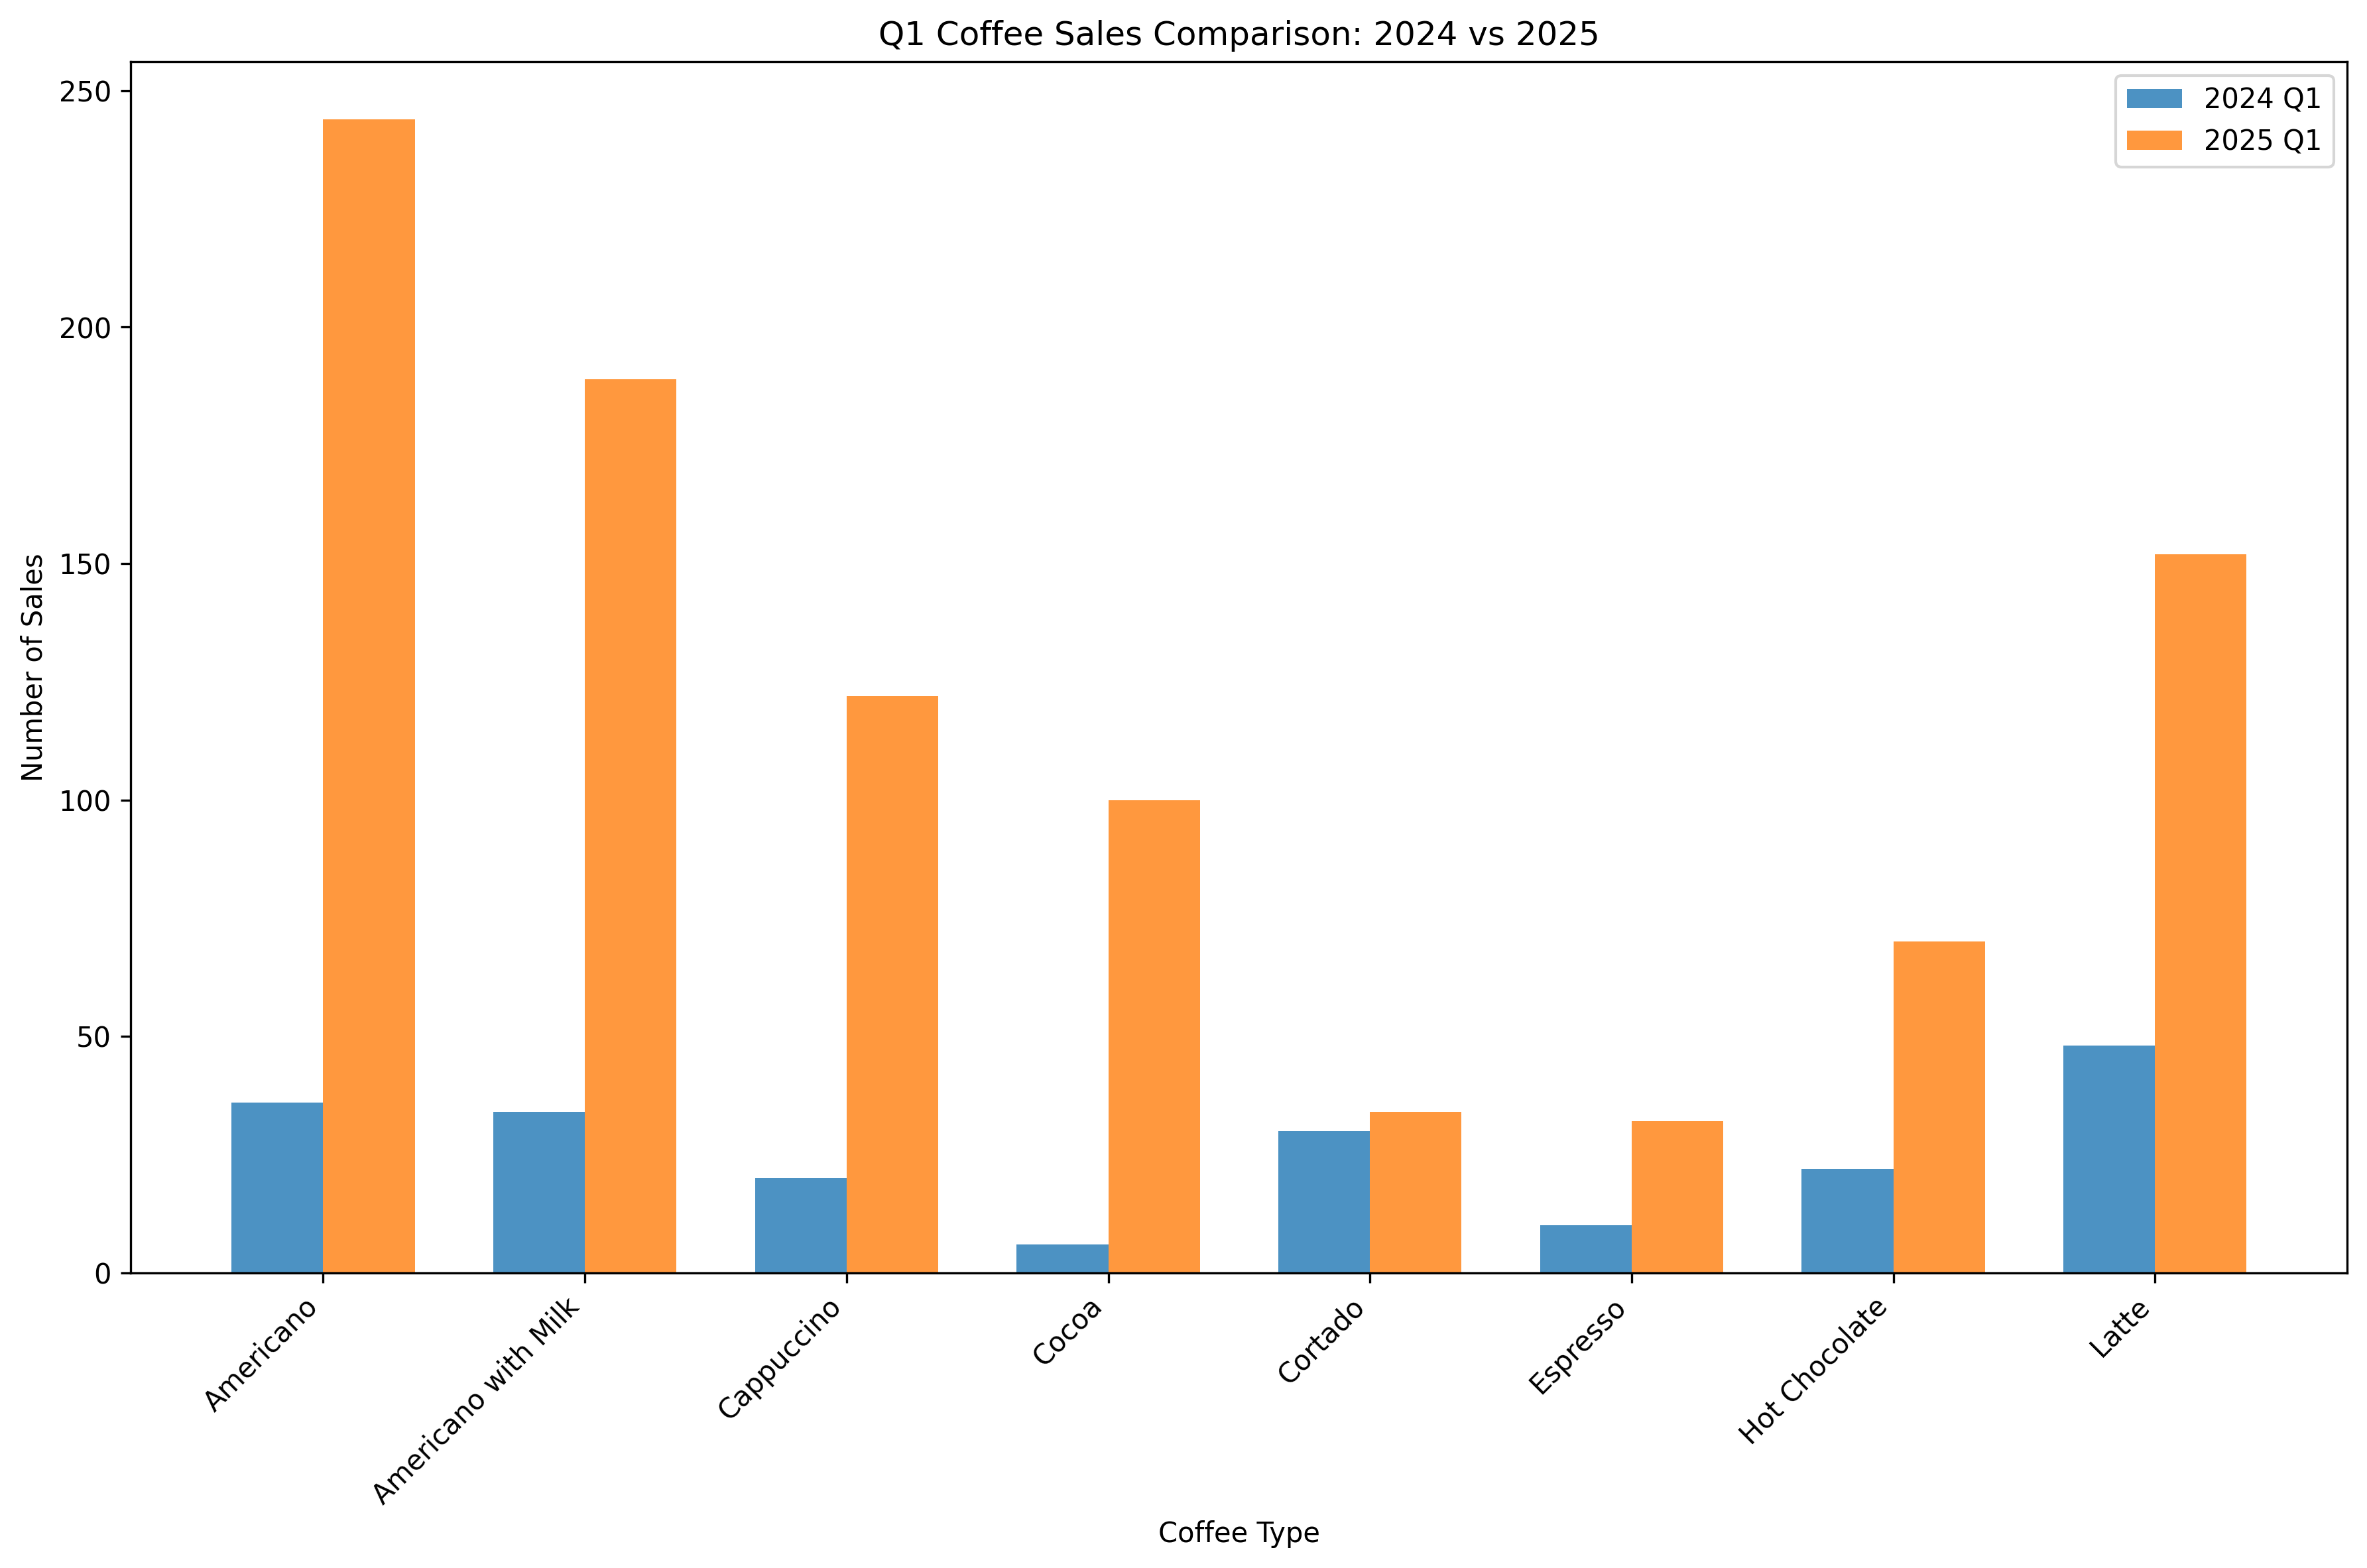


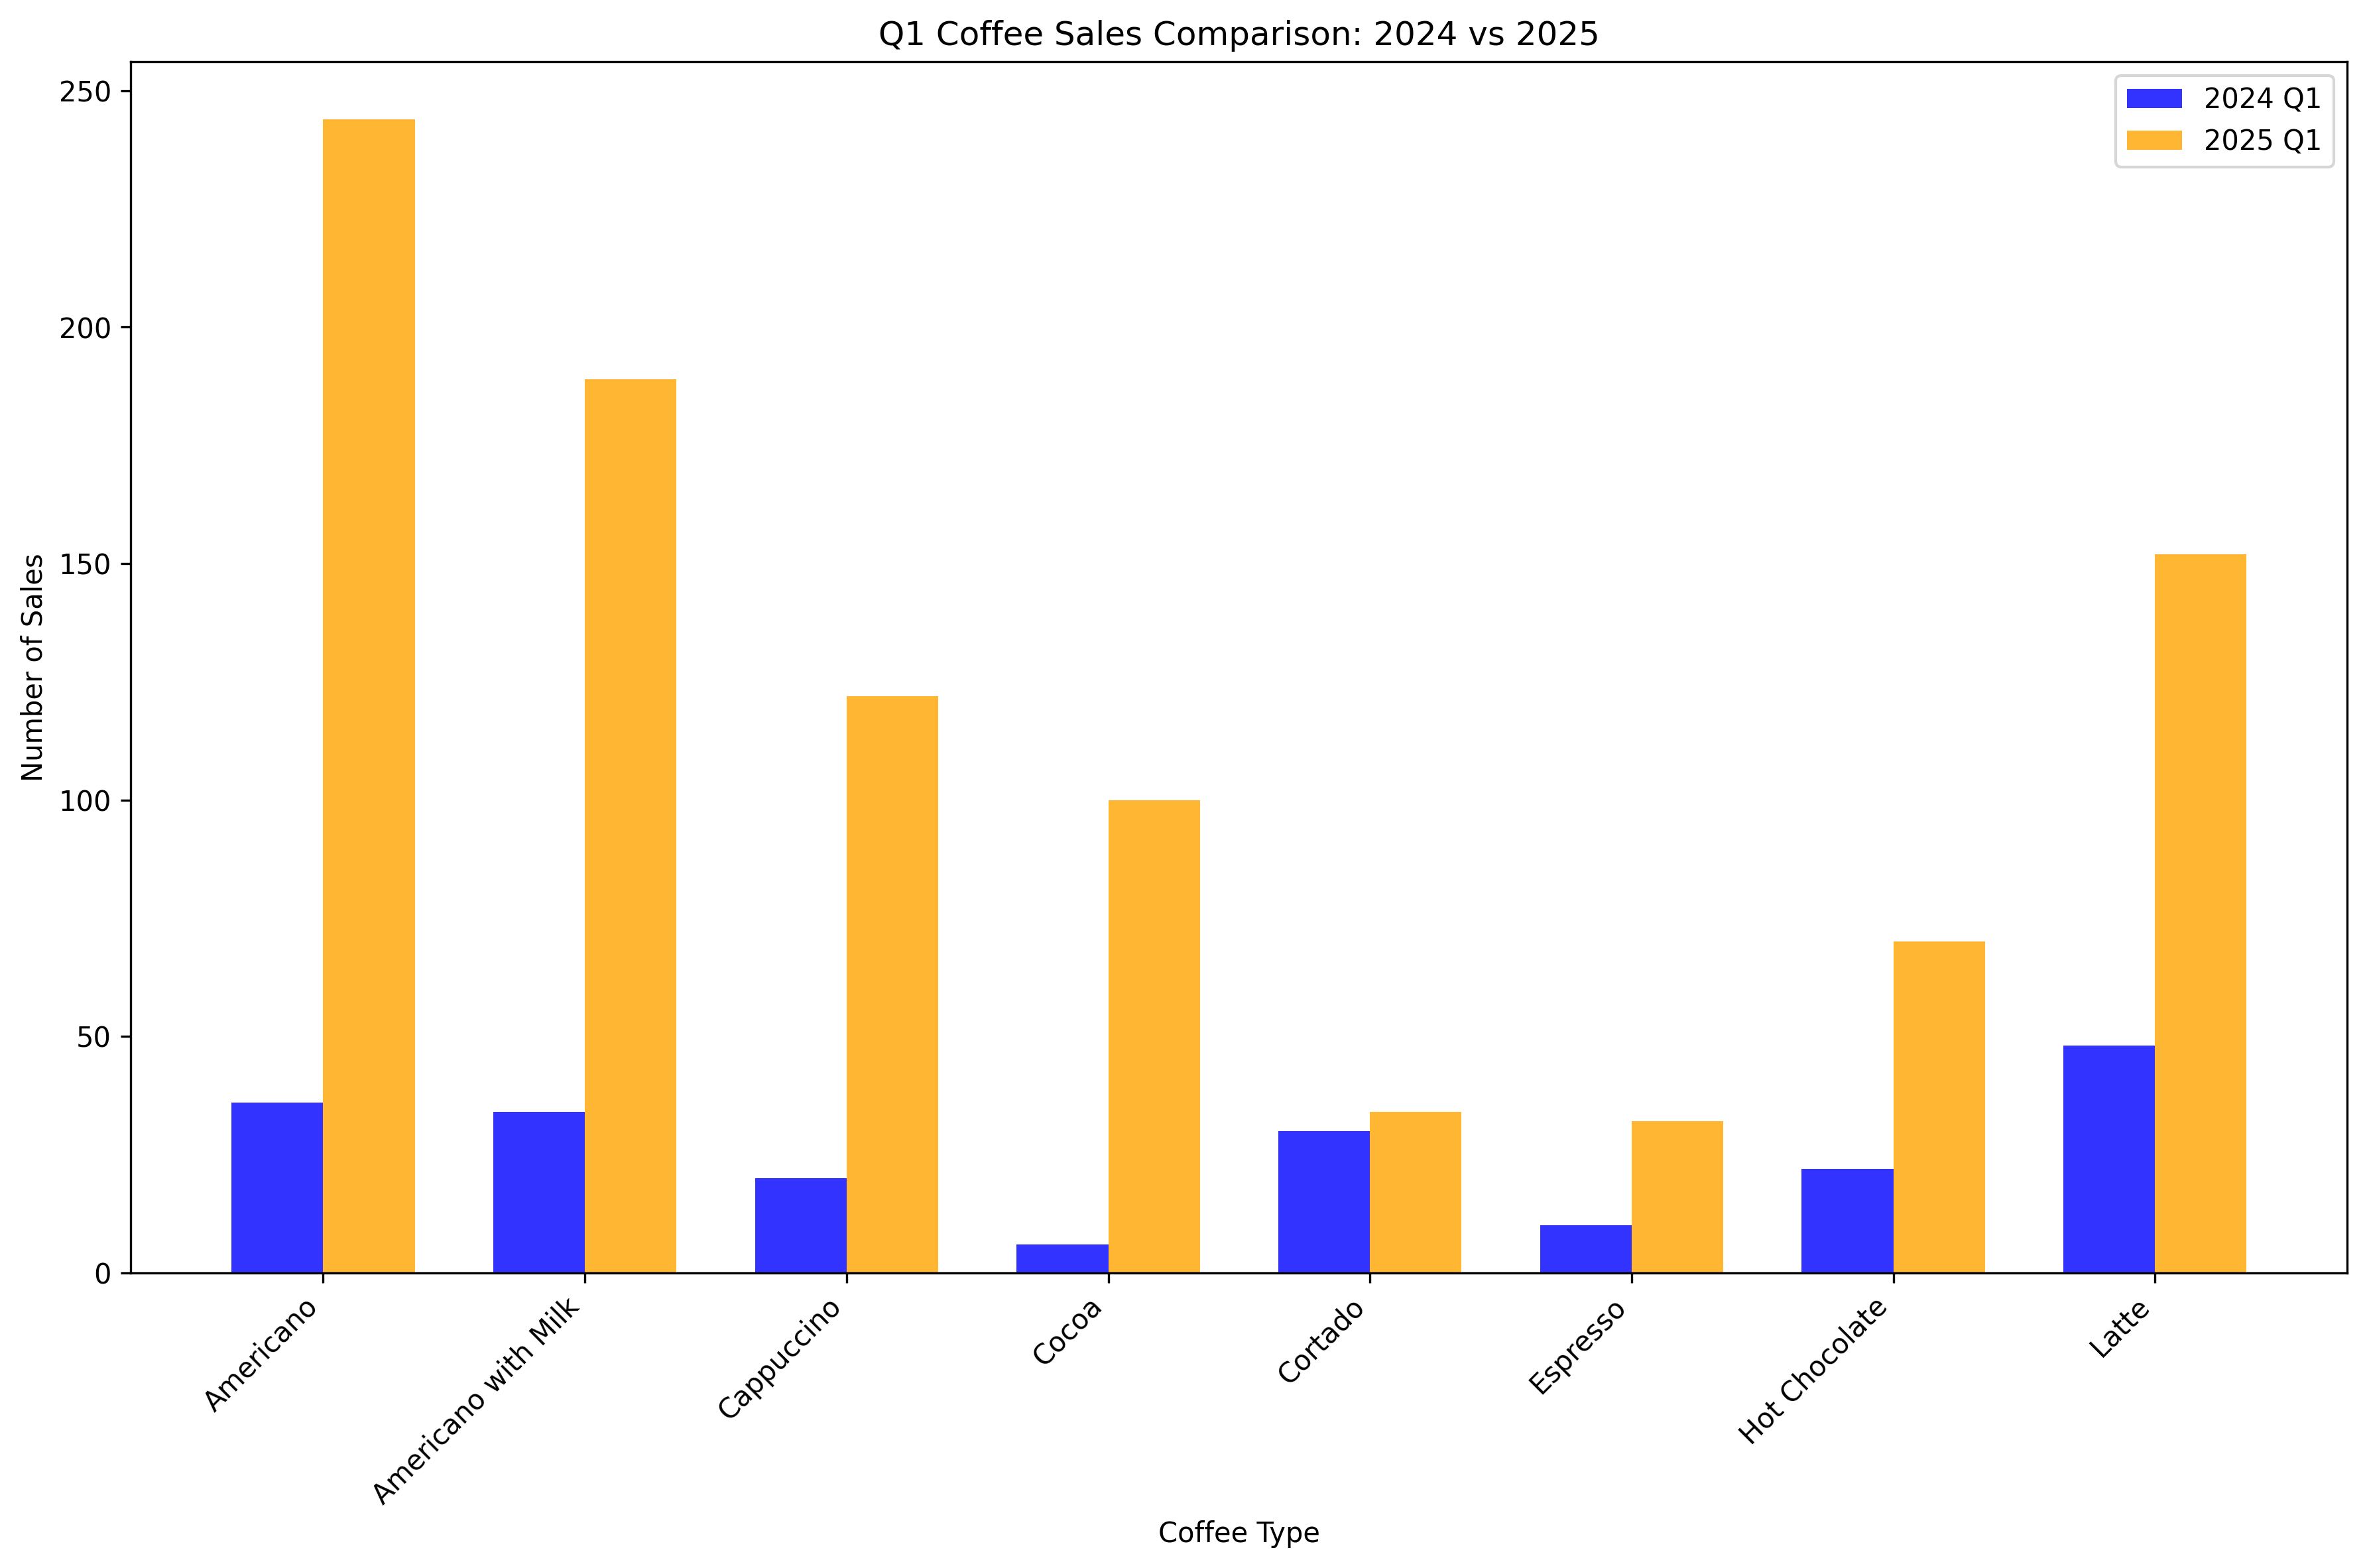

In [21]:
# Here, insert your updates
user_instructions="Create a plot comparing Q1 coffee sales in 2024 and 2025 using the data in coffee_sales.csv." # write your instruction here
generation_model="deepseek-chat" #gpt-4.1-mini
reflection_model="glm-4v-plus" #o4-mini
image_basename="drink_sales"

# Run the complete agentic workflow
_ = run_workflow(
    dataset_path="coffee_sales.csv",
    user_instructions=user_instructions,
    generation_model=generation_model,
    reflection_model=reflection_model,
    image_basename=image_basename
)